Make that we are running the correct version of TensorFlow first

In [1]:
import tensorflow as tf
tf.enable_eager_execution()

tf.__version__

/home/jupyter/.local/share/virtualenvs/line-reader-3vKrZmrE/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jupyter/.local/share/virtualenvs/line-reader-3vKrZmrE/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jupyter/.local/share/virtualenvs/line-reader-3vKrZmrE/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtyp

'1.14.0'

In [2]:
import sys

assert sys.version_info >= (3, 6) # Python ≥3.6 required
# assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

Check devices that can be used by Tensorflow

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3346956519382832652
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5455072039955978619
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8197741768618247613
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14892338381
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1475854472003139871
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


# Train basic model on the generated emnist-lines dataset

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
# To be able to write code as if this notebook was one level up in files tree structure.
sys.path.append('..')

from pathlib import Path

import tensorflow as tf
from tensorflow.python.ops import array_ops
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Model as KerasModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence

import pandas as pd
from PIL import Image

In [5]:
from recognizer.datasets import Dataset
from recognizer.datasets import EmnistDataset
from recognizer.networks import lenet
from recognizer.networks import simple
from recognizer.networks import NetworkInput

In [6]:
model_save_path = Path("../recognizer/weights/lines_all_conv_model.h5")

Hyperparameters

In [7]:
batch_size = 16
epochs = 8

## Load characters mapping

In [8]:
import json

with open(Dataset.raw_data_path()/"emnist"/"emnist_essentials.json") as json_file:  
    mapping = json.load(json_file)["mapping"]
    mapping = {m[0]: m[1] for m in mapping}
    mapping[62] = ' '
    mapping[63] = '_'
    
mapping_reversed = {v: k for k, v in mapping.items()}

## Build the new model

In [9]:
char_image_height = 28
char_image_width = 28
max_length = 34
num_classes = 64
image_height = char_image_height
image_width = char_image_width * max_length

input_shape = (image_height, image_width)
output_shape = (max_length, num_classes)

window_width: float = 16
window_stride: float = 8

In [10]:
def build_model():
    model = Sequential()

    # model.add(layers.Reshape((image_height, image_width, 1), input_shape=input_shape))

    # # Normalize the image
    # model.add(layers.Lambda(lambda x: norm(x, network_input.mean, network_input.std), input_shape=input_shape, output_shape=input_shape))

    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu' , input_shape=(image_height, image_width, 1)))
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.2))
    # (image_height // 2 - 2, image_width // 2 - 2, 64)

    # -2 because we use the default padding which is 'valid' not 'same'.
    # /2 because we did maxPooling with pool size 2, this halved the output size of the previous conv layer.
    new_height = image_height // 2 - 2
    new_width = image_width // 2 - 2
    # Let us also scale the desired window width and stride accordingly.
    new_window_width = window_width // 2 - 2
    new_window_stride = window_stride // 2
    model.add(layers.Conv2D(128, kernel_size=(new_height, new_window_width), strides=(1, new_window_stride), activation='relu'))
    model.add(layers.Dropout(0.2))
    # (1, num_windows, 128)

    num_windows = int((new_width - new_window_width) / new_window_stride) + 1
    model.add(layers.Reshape((num_windows, 128, 1)))
    # (num_windows, 128, 1)

    width = int(num_windows / max_length)
    model.add(layers.Conv2D(num_classes, kernel_size=(width, 128), strides=(width, 1), activation='softmax'))
    # (image_width / width, 1, num_classes)

    model.add(layers.Lambda(lambda x: tf.squeeze(x, 2)))
    # (max_length, num_classes)

    # Since we floor'd the calculation of width, we might have too many items in the sequence. Take only output_length.
    model.add(layers.Lambda(lambda x: x[:, :max_length, :]))
    
    return model

In [11]:
# if model_save_path.exists():
#     print("Load saved model")
    
#     model = keras.models.load_model(model_save_path)
# else:
#     print("Build new model")
    
#     model = build_model()

model = build_model()

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 950, 32)       320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 948, 64)       18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 474, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 474, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 118, 128)       589952    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 118, 128)       0         
_________________________________________________________________
reshape (Reshape)            (None, 118, 128, 1)       0

## Look at the data

In [13]:
df = pd.read_csv(Dataset.processed_data_path()/"emnist_lines"/"data.csv")

output_length = len(df)
output_length

10000

In [14]:
df.head()

,image,sentence
0,0.png,Whats wrong at state _____________
1,1.png,The transducer itself moves the __
2,2.png,There is an ancient and venerable
3,3.png,They destroyed a trading house ___
4,4.png,Alec waited a moment on guard ___


In [15]:
image = Image.open(Dataset.processed_data_path()/"emnist_lines"/"0.png")
image

In [16]:
np.array(image).shape

(28, 952)

## Try it before training

In [17]:
image_numpy = np.array(image).astype(np.float32)
test_batch = image_numpy.reshape(1, image_height, image_width, 1)

preds = model(test_batch)
preds.shape

TensorShape([Dimension(1), Dimension(34), Dimension(64)])

In [18]:
image

In [19]:
for char_pred in preds[0]:
    print(mapping[np.argmax(char_pred)], end='')

YFYYYeb3XY3eebeY6beeetYp0000000000

## Build the generators

Shuffle the data and reset their index

In [20]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,image,sentence
0,4576.png,Using his hands as a trumpet he __
1,8564.png,I suppose I should have paid _____
2,4059.png,Obviously the commanderinchief ___
3,2119.png,There she walked to the far left _
4,5898.png,Interlocking signals are normally


In [21]:
valid_length = int(len(df) * .2)
valid_df = df.iloc[:valid_length]
train_df = df.iloc[valid_length:]

In [22]:
valid_df.tail()

,image,sentence
1995,9374.png,But the price was the silence of _
1996,9873.png,I cant find it in the glove _____
1997,6607.png,once in power he begins to give __
1998,2344.png,Substances ______________________
1999,8329.png,I frankly cant draw a straight ___


In [23]:
train_df.head()

,image,sentence
2000,8952.png,And he dismissed the colored _____
2001,9216.png,This twopart bridge is best ______
2002,554.png,His sense for rhythmic variety ___
2003,7285.png,After a prolonged study of the ___
2004,1315.png,This accords with the study by ___


In [24]:
class LinesDataSequence(Sequence):
    
    def __init__(self, df, batch_size=32):
        self.df = df
        self.batch_size = batch_size

    def __len__(self):
        return len(self.df) // batch_size

    def __getitem__(self, idx):
        """Return a single batch."""
        begin = idx * self.batch_size
        end = min(len(df) - 1, (idx + 1) * self.batch_size)
        
        batch_x = []
        batch_y = []
        for index in range(begin, end):
            row = self.df.iloc[index]
            
            image = Image.open(Dataset.processed_data_path()/'emnist_lines'/row['image'])
            x = np.array(image).astype(np.float32).reshape(image_height, image_width, 1)
            batch_x.append(x)

            y = [mapping_reversed[char] for char in row['sentence']]
            y = to_categorical(y, num_classes).astype(np.int)
            batch_y.append(y)

        return np.array(batch_x), np.array(batch_y)

## Train

Check progress in TensorBoard by running `tensorboard --logdir=logs/lines_all_conv` in terminal

In [25]:
!rm -r ../logs/lines_all_conv

callbacks = [
    keras.callbacks.TensorBoard(log_dir='../logs/lines_all_conv')
]

In [26]:
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
history = model.fit_generator(
    LinesDataSequence(train_df, batch_size),
    steps_per_epoch=len(train_df) // batch_size,
    validation_data=LinesDataSequence(valid_df, batch_size),
    validation_steps=len(valid_df) // batch_size,
    epochs=epochs,
    callbacks=callbacks)
history.history.keys()

W0826 04:21:36.216198 139660876486400 deprecation.py:323] From /home/jupyter/.local/share/virtualenvs/line-reader-3vKrZmrE/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/8
  1/500 [..............................] - ETA: 14:53 - loss: 5.0056 - acc: 0.0147

W0826 04:21:37.964916 139660876486400 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.176521). Check your callbacks.


500/500 [==============================] - 25s 51ms/step - loss: 2.8220 - acc: 0.2408 - val_loss: 2.6872 - val_acc: 0.2579
Epoch 2/8
500/500 [==============================] - 24s 47ms/step - loss: 2.6925 - acc: 0.2594 - val_loss: 2.6795 - val_acc: 0.2650
Epoch 3/8
500/500 [==============================] - 23s 47ms/step - loss: 2.6712 - acc: 0.2635 - val_loss: 2.6614 - val_acc: 0.2663
Epoch 4/8
500/500 [==============================] - 23s 47ms/step - loss: 2.6565 - acc: 0.2659 - val_loss: 2.6730 - val_acc: 0.2671
Epoch 5/8
500/500 [==============================] - 23s 47ms/step - loss: 2.6466 - acc: 0.2689 - val_loss: 2.6607 - val_acc: 0.2663
Epoch 6/8
500/500 [==============================] - 24s 47ms/step - loss: 2.6398 - acc: 0.2695 - val_loss: 2.6518 - val_acc: 0.2691
Epoch 7/8
500/500 [==============================] - 24s 47ms/step - loss: 2.6329 - acc: 0.2711 - val_loss: 2.6689 - val_acc: 0.2699
Epoch 8/8
500/500 [==============================] - 24s 47ms/step - loss: 2.63

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

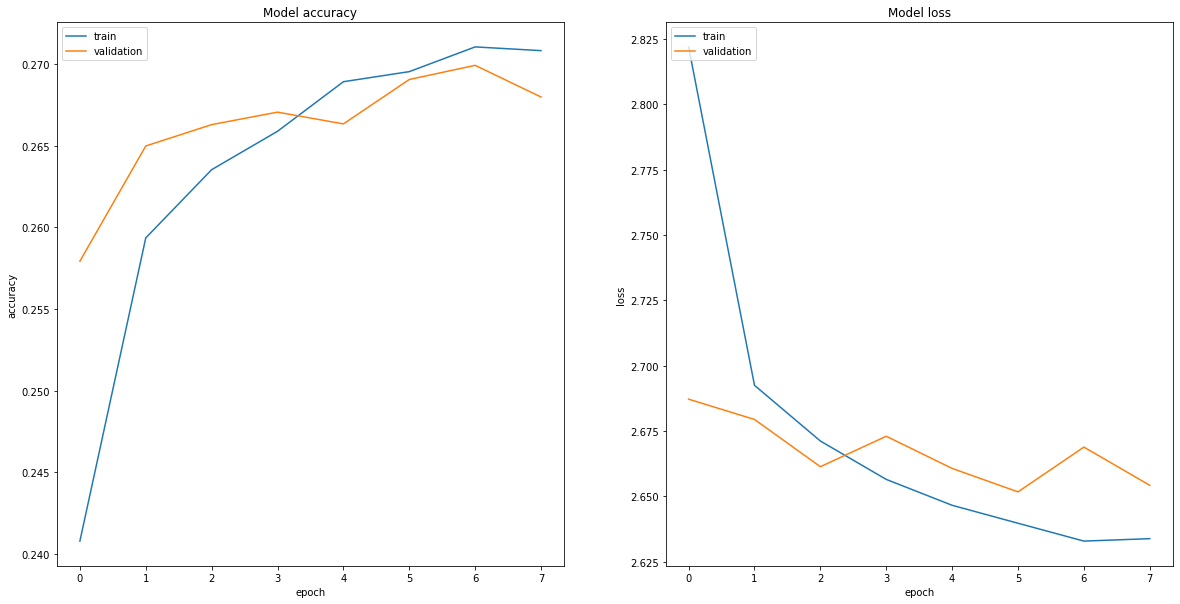

In [28]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

# Save the model

In [29]:
model_save_path

PosixPath('../recognizer/weights/lines_all_conv_model.h5')

In [30]:
model.save(model_save_path)

## Restore the model

In [31]:
# model = keras.models.load_model(model_save_path)

## Predict

In [32]:
model.trainable = False

# Compile the model for trainable changes to take effect.
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
preds = model(test_batch)
preds.shape

TensorShape([Dimension(1), Dimension(34), Dimension(64)])

In [34]:
image

In [35]:
for char_pred in preds[0]:
    print(mapping[np.argmax(char_pred)], end='')

Wh           e   s   ee __________